In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [79]:
start_line = 6

data = pd.read_csv('Thesis_Samples_Data/Test/TestRun11.csv', skiprows=start_line)
data = data.drop([0])
data

,Crosshead,Load,Time (sec),Extensometer
1,-0.000098,-3.087354,0.200000,0.000012
2,-0.000146,-3.070797,0.300000,0.000026
3,-0.000146,-3.063200,0.400000,0.000027
4,-0.000244,-3.056753,0.500000,0.000033
5,-0.000293,-3.096555,0.600000,0.000044
...,...,...,...,...
2966,-0.247217,-102.089020,296.700012,0.137504
2967,-0.247266,-101.966217,296.799988,0.137621
2968,-0.247363,-101.899727,296.899994,0.137750
2969,-0.247461,-101.833717,297.000000,0.137900


0.0


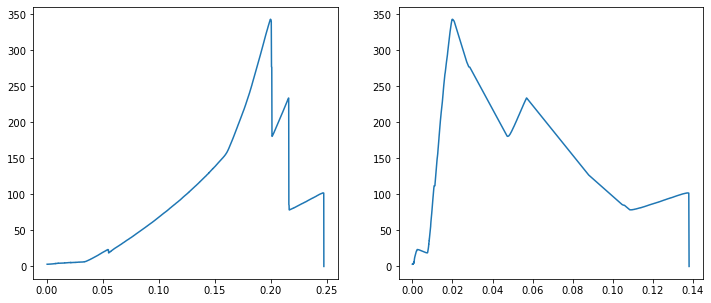

In [80]:
# get relevant columns and preprocess
crosshead = data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
extenso = data.loc[:, 'Extensometer '].to_numpy(dtype=np.double)
load = data.loc[:, 'Load '].to_numpy(dtype=np.double)

crosshead = abs(crosshead)

min_extenso = np.min(extenso)
if (min_extenso < 0):
    extenso = extenso + abs(min_extenso)
extenso = abs(extenso)

load = abs(load)

stop_index = 2978 - start_line
crosshead = crosshead[0:stop_index]
extenso = extenso[0:stop_index]
load = load[0:stop_index]

print(load[-1])

plt.figure(figsize=(12, 5))

sub = plt.subplot(1, 2, 1)
sub.plot(crosshead, load)

sub = plt.subplot(1, 2, 2)
sub.plot(extenso, load)

### Define Sample Parameters

In [53]:
S = 120      # span, mm
B = 40   # width, mm
B_N = B      # side-groove width, mm
W = 40   # thickness, mm
a0 = 4   # initial crack length, mm
E = 25000    # young's modulous, MPa


## K<sub>ic</sub> Calculation

![title](img/K_ic.png)

Where K<sub>(i)</sub> = K<sub>ic</sub>, P<sub>i</sub> = P<sub>max</sub> (the first, highest peak), and 
![title](img/f_a_W.png)

with a<sub>i</sub> = a<sub>0</sub>

[From E1820]

In [54]:
a_W = a0/W
f_aW = 3*np.sqrt(a_W) * (1.99 - a_W*(1-a_W)*(2.15-3.93*a_W+2.7*a_W**2)) / (2*(1+2*a_W)*np.power(1-a_W, 1.5))

P_max = np.max(load)
pl_index = np.argmax(load)

K_ic = (P_max*S/(np.sqrt(B*B_N)*np.power(W, 1.5))) * f_aW
K_ic

3.4463912625472863

## J<sub>el</sub> Calculation

![title](img/J_el.png)

[from Bouville et al]

E is the young's modulous, so it must first be calulated from the (roughly) linear region before the first peak:

![title](img/modulous.png)

![title](img/wikipedia_terms.png)

[from Wikipedia]

In [55]:
# first find slope of linear load-displacement region
num_reg_points = int(pl_index / 5)
crosshead_reg = crosshead[pl_index-num_reg_points:pl_index]
load_reg = load[pl_index-num_reg_points:pl_index]
A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]

# then calculate E
E_reg = (S**3 * m) / (4*B*W**3)
print(E_reg)

# finally J_el
J_el = K_ic**2/E
J_el

808.796013409793


0.00047510450938249117

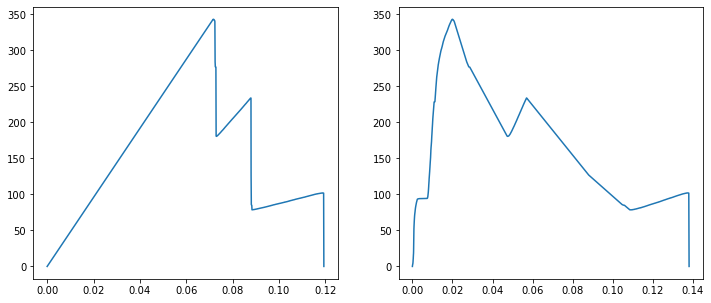

In [85]:
# create linearized load-displacement and load-extensometer graphs

crosshead_P_max = crosshead[pl_index]

# generate new data values where lead-up to peak is linearized
crosshead_x_int = crosshead_P_max - (P_max/m)

crosshead_P_max = crosshead[pl_index]
crosshead_el = np.linspace(0, crosshead_P_max-crosshead_x_int, num=pl_index)
load_el = m * np.copy(crosshead_el)

# plt.plot(crosshead_el, load_el)

crosshead_linearized = np.concatenate((crosshead_el, crosshead_pl-crosshead_x_int))
load_linearized = np.concatenate((load_el, load_pl))

plt.figure(figsize=(12, 5))

sub = plt.subplot(1, 2, 1)
sub.plot(crosshead_linearized, load_linearized)

sub = plt.subplot(1, 2, 2)
sub.plot(extenso, load_linearized)


## J<sub>pl</sub> Calculation (using crosshead)

![title](img/J_pl_Bouville.png)

Where A<sub>pl</sub> is the cumulative area under the load-crosshead curve post-peak (after initial max load point) and is calculated using a trapezoidal sum. b = W - a<sub>0</sub>.

[from Bouville et al]

In [57]:
crosshead_pl = crosshead[pl_index:]
extenso_pl = extenso[pl_index:]
load_pl = load[pl_index:]

n_pl = load_pl.shape[0]
A_pl = np.zeros(n_pl)

A_pl[0] = 0.5*(load[pl_index]+load[pl_index-1]) * (crosshead[pl_index]-crosshead[pl_index-1])
for i in range(1, n_pl):
    A_pl[i] = A_pl[i-1] + 0.5*(load_pl[i]+load_pl[i-1]) * (crosshead[i]-crosshead[i-1])
    
J_pl = 1.9*A_pl/(B*(W-a0))

## Crack Length Determination (using crosshead)

To plot an R-curve, K<sub>jc</sub> must be plotted against the crack length a<sub>i</sub>:

![title](img/crack_length_Bouville.png)

with

![title](img/C_Bouville.png)

where u = crosshead displacement and f = load

[from Bouville et al]

In [75]:
C = np.divide(crosshead_pl, load_pl, where=load_pl!=0)

a = np.zeros(n_pl)

a[0] = a0
for i in range(1, n_pl):
    if (C[i] != 0):
        a[i] = a[i-1] + 0.5*(W-a[i-1])*((C[i]-C[i-1])/C[i])
    else: a[i] = W
    

## Crack Length Determination (using CMOD)

An alternative method, using equations from ASTM E399

![title](img/a_E399.png)

with

![title](img/E_prime.png)

In [77]:
B_e = B-((B-B_N)**2)/B

U = 1/(1+np.sqrt((E*B_e*extenso_pl*1e1/(load_pl+1e-50))) * 4*W/S)
print(load_pl[-1])

# a = (a/W)*W

a_E399 = W*(1 - 3.950*U + 2.982*np.power(U, 2) - 3.214*np.power(U, 3) + 5.516*np.power(U, 4) - 113.031*np.power(U, 5))

offset = abs(a_E399[0] - a0)
print(offset)
if (a_E399[0] < a0): a_E399 = a_E399 + offset
else: a_E399 = a_E399 - offset

# compare
print(a)
print(a_E399)

0.0
31.327139840520573
[ 4.          4.01298615  4.01581095  4.02769955  4.03452195  4.04622459
  4.08625729  4.11299039  4.13917906  4.17805562  4.25772191  7.18642041
  7.59247541  7.60850992  7.61326313  7.63458914 13.24102922 13.26826186
 13.27377579 13.26481275 13.26123862 13.25055475 13.24581481 13.22965565
 13.21533779 13.19555844 13.18416624 13.16791512 13.15375141 13.13210801
 13.12201826 13.1106588  13.09473222 13.07914142 13.06105807 13.04599092
 13.02689453 13.01458717 12.99818794 12.98521426 12.97104033 12.95698573
 12.9371274  12.91204876 12.90018768 12.88125011 12.87252345 12.8602218
 12.84214125 12.82715777 12.81141381 12.79583619 12.77411289 12.75676791
 12.74448232 12.72627093 12.70544996 12.69905731 12.68009711 12.660945
 12.64630638 12.63126578 12.61145794 12.59308737 12.58000823 12.56614046
 12.54734554 12.53802854 12.52064614 12.50467132 12.49238941 12.4744751
 12.45567099 12.44452934 12.42546825 12.42243866 12.40575673 12.38564728
 12.37296338 12.35229883 12.3414

## K<sub>jc</sub> Calculation

![title](img/K_jc_Bouville.png)

This is an elemnt-wise calculation for plotting during the plastic region. An overall K<sub>jc</sub> can be found by taking the last/maximum value from this array.

[from Bouville et al]

In [43]:
K_jc = np.sqrt((J_el+J_pl)*E)
K_jc_overall = np.max(K_jc)
K_jc_overall

14.941749874930906

## Plotting

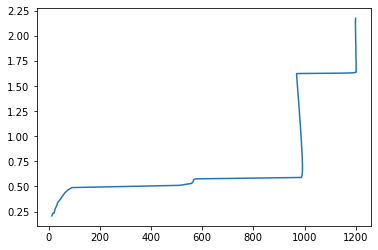

In [12]:
plt.plot(a_E399, K_jc)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

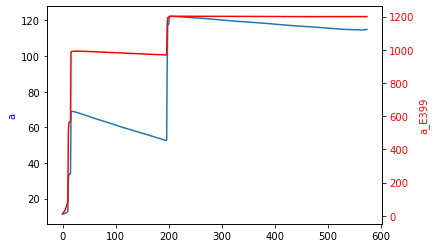

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a)
ax1.set_ylabel('a', color='b')

ax2 = ax1.twinx()
ax2.plot(a_E399, 'r-')
ax2.set_ylabel('a_E399', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.plot